# Whale Classifier

In [41]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [42]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import dill as pickle

In [43]:
PATH = './data/whale/'
arch = resnet34
sz = 224
bs = 64

In [44]:
label_csv = f'{PATH}train.csv'
val=[0]

In [45]:
# train_df = pd.read_csv(label_csv)
# train_df['Id'] = train_df['Id'].astype('category')
# whale_ids = train_df['Id'].unique()
# whale_ids2num = {k: v for k,v in zip(whale_ids, range(len(whale_ids)))}
# train_df['Id'] = train_df['Id'].map(whale_ids2num)
# train_df.to_csv(label_csv, index=False)
# pickle.dump(whale_ids2num, open('whale_ids2num.pkl', 'wb'))

# Data Transform

In [46]:
augs = [
    RandomFlip(),
    RandomLighting(0.1, 0.1),
    RandomRotate(3)
]

def get_data(sz, bs, val):
    tfms = tfms_from_model(arch, sz, aug_tfms=augs, crop_type=CropType.NO)
    data = ImageClassifierData.from_csv(PATH, 'train', label_csv, test_name='test',
                                        val_idxs=val, tfms=tfms, bs=bs)
    return data

# Find Learning Rate

In [47]:
data = get_data(sz,bs,val_idxs)

In [48]:
learn = ConvLearner.pretrained(arch, data, ps=0.5)

In [49]:
lrf = learn.lr_find()

 93%|█████████▎| 115/124 [00:54<00:04,  2.13it/s, loss=20.6]

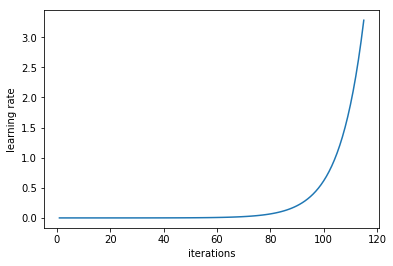

In [50]:
learn.sched.plot_lr()

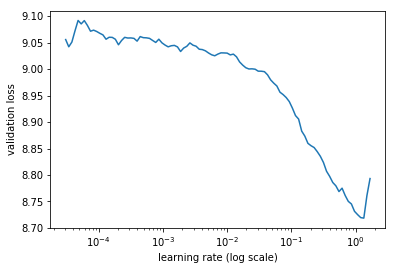

In [51]:
learn.sched.plot()

In [52]:
lr = 1e-1

In [53]:
lrs = np.array([lr/100,lr/10,lr/3])

# Improve Model

In [54]:
learn.fit(lr, 3)

epoch      trn_loss   val_loss   accuracy                   
    0      7.982651   7.626327   0.080711  
    1      7.122971   7.308795   0.080711                   
    2      6.479996   7.074593   0.092386                   


[array([7.07459]), 0.09238578681715853]

In [55]:
learn.precompute = False

In [56]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      5.451615   6.974283   0.112183  
    1      5.087379   6.909038   0.124873                   
    2      4.69111    6.878747   0.135533                   


[array([6.87875]), 0.1355329948557815]

In [57]:
learn.save('resnet34_224_lastlayer3')

In [58]:
learn.load('resnet34_224_lastlayer3')

In [59]:
learn.unfreeze()

In [60]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      5.349636   6.873824   0.119797  
    1      4.849506   6.699114   0.14264                    
    2      3.887237   6.540778   0.17665                    
    3      4.126432   6.697794   0.159391                   
    4      3.552085   6.584331   0.188832                   
    5      2.810508   6.448742   0.215736                   
    6      2.436476   6.421862   0.22132                    


[array([6.42186]), 0.22131979702995513]

In [61]:
learn.save('resnet34_224_all3')

In [62]:
learn.load('resnet34_224_all3')

# Increase Data Image Size

In [63]:
sz = 320

In [64]:
data = get_data(sz,bs,val_idxs)
learn.set_data(data)

In [65]:
learn.freeze()

In [66]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      3.451028   6.587083   0.2       
    1      3.15319    6.548017   0.21066                    
    2      2.799923   6.674218   0.220812                   


[array([6.67422]), 0.2208121830436784]

In [67]:
learn.save('resnet34_320_last_layer3')

In [68]:
learn.load('resnet34_320_last_layer3')

In [69]:
learn.unfreeze()

In [70]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      2.315403   6.52256    0.242132  
    1      2.306968   6.756538   0.230457                   
    2      1.558903   6.582802   0.249746                   
    3      1.958345   6.95591    0.232487                   
    4      1.610316   6.957217   0.250761                   
    5      1.144293   6.834897   0.262437                   
    6      0.871389   6.848128   0.263452                    


[array([6.84813]), 0.2634517764682092]

In [71]:
learn.save('resnet34_320_all3')

In [72]:
learn.load('resnet34_320_all3')

# Create Submission

In [73]:
probs, _ = learn.TTA(is_test=True)

In [74]:
# Assemble our data frame
mean_probs = np.mean(probs, axis=0) # Average probs from TTA
probs_sorted = np.argsort(-mean_probs,axis=1)[:,:5] # Get top 5 predictions

In [75]:
import dill as pickle
whale_ids2num = pickle.load(open('whale_ids2num.pkl', 'rb'))

In [76]:
fnames = [f[5:] for f in data.test_ds.fnames] # get rid of folder prefix

num2whale = [k for k,v in whale_ids2num.items()]

def probs2whale(x):
    return num2whale[int(data.classes[x])]

probs2whale = np.vectorize(probs2whale)

def join_with_spaces(arr):
    return ' '.join(arr)

whales = np.apply_along_axis(join_with_spaces, 1, probs2whale(probs_sorted))

In [77]:
df = pd.DataFrame({'Image': fnames, 'Id': whales}, columns=['Image','Id'])
df.to_csv('submission5.csv', index=False)

Kaggle Score: 0.39446